# Lesson 1: Is it a bird?

In 2015, the idea of being able to quickly create a system which could identify a bird was basically magic and impossible with the current technology:

![xkcd_bird](files/01/xkcd_bird.png)

So, let's do it in one Python notebook now using simple DL techniques!

The high-level steps for this will be:
1. Use DDG to search for 'bird pictures'
2. Use DDG to search for 'forest pictures'
3. Fine-tune a pretrained neural network to recognise these 2 groups
4. Try running this model on a picture of a bird to see if it works

## §0: Setup

In [1]:
# Import time!
from loguru import logger
from rich.logging import RichHandler

from fastcore.all import *

# Logging setup
logger.configure(
    handlers=[
        {
            "sink": RichHandler(
                log_time_format="%Y-%m-%d %X",
                rich_tracebacks=True,
                show_path=False,
                tracebacks_width=200,
            ),
            "format": "{message}",
            "level": "DEBUG",
        }
    ]
)

[1]

In [9]:
# Explicitly configure `torch` to use `mps` if available
from fastai.torch_core import default_device

default_device(-1)
print(default_device().type)

mps


## §1: Download images

Let's start by finding a bird photo from DDG:

In [2]:
# Helper functions for image retrieval
from duckduckgo_search import DDGS
from toolz.itertoolz import take


def search_images(search_term: str, max_images: int = 30) -> L:
    logger.debug(f"Searching for '{search_term}'")
    # return L(ddg_images(search_term, max_results=max_images)).itemgot('image')
    search_image_list = L()
    with DDGS() as ddgs:
        ddg_image_gen = ddgs.images(search_term)
        search_image_list = L(take(max_images, ddg_image_gen))

    return search_image_list.itemgot("image")

In [3]:
# NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
# If you get a JSON error, just try running it again (it may take a couple of tries).

validation_bird_urls = search_images("bird photos", max_images=1)
logger.info(f"Test bird picture URL = {validation_bird_urls[0]}")

2023-08-14 16:02:18 DEBUG    Searching for 'bird photos'

2023-08-14 16:02:19 INFO     Test bird picture URL =                                                               
                             https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg

With this URL, it's time to download the picture and save it somewhere sensible for later:

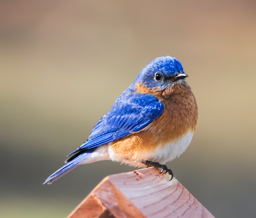

In [4]:
from fastdownload import download_url
from fastai.vision.all import Image

destination = "bird.jpg"
download_url(validation_bird_urls[0], destination, show_progress=False)

%matplotlib inline
image_obj = Image.open(destination)
image_obj.thumbnail((256, 256))
image_obj

Now it's time to do the same with a forest photo as well

2023-08-14 16:02:21 DEBUG    Searching for 'forest photos'

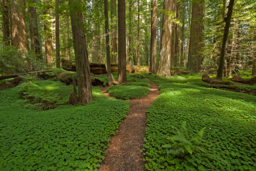

In [5]:
download_url(
    search_images("forest photos", max_images=1)[0], "forest.jpg", show_progress=False
)

forest_test_photo = Image.open("forest.jpg")
forest_test_photo.thumbnail((256, 256))
forest_test_photo

These searches seem like they're going well, so it's time to collect a few examples of the right type of photo to test with, each with different lighting conditions:

In [6]:
from time import sleep

from fastai.vision.all import download_images, resize_images

search_terms = ["forest", "bird"]
images_root_folder = Path("bird_or_not")

for search in search_terms:
    image_destination_folder = images_root_folder / search
    image_destination_folder.mkdir(exist_ok=True, parents=True)

    # First, download basic photos of `search`
    download_images(image_destination_folder, urls=search_images(f"{search} photo"))
    sleep(10)  # Pause to stop overloading the server

    # Next, pictures in the sun
    download_images(image_destination_folder, urls=search_images(f"{search} sun photo"))
    sleep(10)

    # Next, pictures in the shade
    download_images(
        image_destination_folder, urls=search_images(f"{search} shade photo")
    )
    sleep(10)

    resize_images(image_destination_folder, max_size=400, dest=image_destination_folder)

2023-08-14 16:02:23 DEBUG    Searching for 'forest photo'

2023-08-14 16:02:40 DEBUG    Searching for 'forest sun photo'

2023-08-14 16:02:54 DEBUG    Searching for 'forest shade photo'

2023-08-14 16:03:10 DEBUG    Searching for 'bird photo'

2023-08-14 16:03:25 DEBUG    Searching for 'bird sun photo'

2023-08-14 16:03:39 DEBUG    Searching for 'bird shade photo'

## §2: Training the model

Some photos may have been downloaded incorrectly, so we need to remove them:

In [7]:
from fastai.vision.all import verify_images, get_image_files

failed_images = verify_images(get_image_files(images_root_folder))
failed_images.map(Path.unlink)
logger.debug(f"Number of failed image downloads = {len(failed_images)}")

2023-08-14 16:03:52 DEBUG    Number of failed image downloads = 3

Next, to create our dataset that will be used to train our model, we shall use the `DataLoader` class, which will allow to configure data such as:
- Training/validation set
- What type of structure the data is in
- What transforms should be applied to the inputs

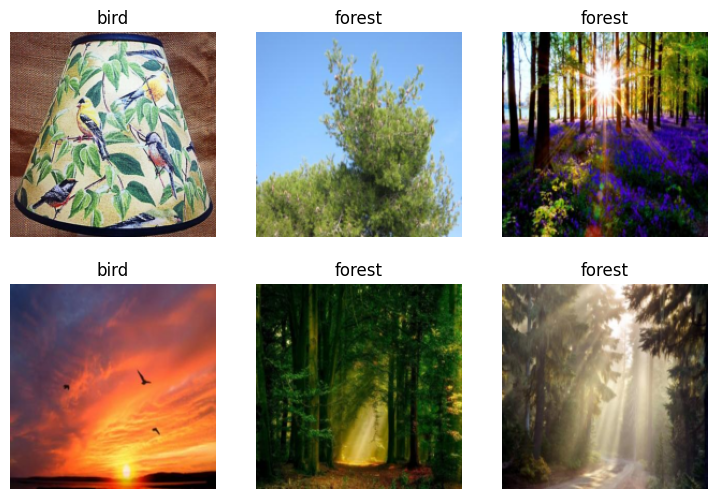

In [8]:
from fastai.vision.all import (
    DataBlock,
    ImageBlock,
    CategoryBlock,
    RandomSplitter,
    Resize,
    parent_label,
)

dls = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=100),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")],
).dataloaders(images_root_folder, bs=32)

dls.show_batch(max_n=6)

This is what each of the inputs to `DataLoaders` means:

```
blocks=[ImageBlock, CategoryBlock],
```
This specifies that the input to our model are images, and the outputs aare categories ("bird" or "forest")

```
get_items=get_image_files,
```
To find all of the images that should be input, the `get_images_files` should be used to find all the images in a path

```
splitter=RandomSplitter(valid_pct=0.2, seed=100),
```
This splits the data into training and validation sets randomly, with 20% of the images being saved for validation

```
get_y=parent_label,
```
The `y` values (training label) is the name of the parent folder for each of the images (either brid or forest)

```
item_tfms=[Resize(192, method="squish")],
```
Before training, resize each image to 192x192 pixels by "squishing" it instead of cropping it

Now we are ready to train our model. We'll use `resnet18` which easily works in this usecase.

To customise the model for our usecase, we'll use the `fine_tune` method which uses best practices to fine tune a pre-trained model

In [10]:
from fastai.vision.all import vision_learner, resnet18, error_rate

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/kmccarro/miniconda3/envs/fast_ai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kmccarro/miniconda3/envs/fast_ai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/kmccarro/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 33.0MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.497271,0.068057,0.029703,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.047980,0.000394,0.000000,00:03
1,0.028545,0.000542,0.000000,00:02
2,0.018561,0.001819,0.000000,00:02


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the free fast.ai course.

## §3: Use our model!

Let's see hat our model thinks of the test images we downloaded at the start...

In [11]:
from fastai.vision.all import PILImage

is_bird, _, probs, *__ = learn.predict(PILImage.create("bird.jpg"))
logger.info(f"This is a: {is_bird}")
logger.info(f"Probability it's a bird: {probs[0]:.4f}")

2023-08-14 16:19:47 INFO     This is a: bird

                    INFO     Probability it's a bird: 1.0000

\o/